In [1]:
import sys
import os
import re
import pickle
import pandas as pd
import numpy as np
import random
import tensorflow as tf
from transformers import TFBertModel,BertTokenizer
from sklearn.preprocessing import StandardScaler
import sys
import os
import re
import pickle


DATA_PATH = '../data/MOSEI/'

def to_pickle(obj, path):
    with open(path, 'wb') as f:
        pickle.dump(obj, f)

def load_pickle(path):
    with open(path, 'rb') as f:
        return pickle.load(f)

def get_length(x):
    return x.shape[1]-(np.sum(x, axis=-1) == 0).sum(1)

# first we align to words with averaging, collapse_function receives a list of functions
# dataset.align(text_field, collapse_functions=[avg])
# load pickle file for unaligned acoustic and visual source
pickle_filename = DATA_PATH+'mosei_senti_data_noalign.pkl'
csv_filename = DATA_PATH+'MOSEI-label.csv'

with open(pickle_filename, 'rb') as f:
    d = pickle.load(f)

# read csv file for label and text
df = pd.read_csv(csv_filename)
text = df['text']
vid = df['video_id']
cid = df['clip_id']

train_split_noalign = d['train']
dev_split_noalign = d['valid']
test_split_noalign = d['test']

# a sentinel epsilon for safe division, without it we will replace illegal values with a constant
EPS = 1e-6

# place holders for the final train/dev/test dataset
train = train = []
dev = dev = []
test = test = []

# define a regular expression to extract the video ID out of the keys
# pattern = re.compile('(.*)\[.*\]')
pattern = re.compile('(.*)_([.*])')
num_drop = 0 # a counter to count how many data points went into some processing issues

v = np.concatenate((train_split_noalign['vision'],dev_split_noalign['vision'], test_split_noalign['vision']),axis=0)
vlens = get_length(v)

a = np.concatenate((train_split_noalign['audio'],dev_split_noalign['audio'], test_split_noalign['audio']),axis=0)
alens = get_length(a)

label = np.concatenate((train_split_noalign['labels'],dev_split_noalign['labels'], test_split_noalign['labels']),axis=0)

L_V = v.shape[1]
L_A = a.shape[1]


all_id = np.concatenate((train_split_noalign['id'], dev_split_noalign['id'], test_split_noalign['id']),axis=0)[:,0]
all_id_list = all_id.tolist()

train_size = len(train_split_noalign['id'])
dev_size = len(dev_split_noalign['id'])
test_size = len(test_split_noalign['id'])

dev_start = train_size
test_start = train_size + dev_size

all_csv_id = [(vid[i], str(cid[i])) for i in range(len(vid))]

for i, idd in enumerate(all_id_list):
    # get the video ID and the features out of the aligned dataset

    # matching process
    try:
        index = i
    except:
        import ipdb; ipdb.set_trace()

    _words = text[index].split()
    _label = label[i].astype(np.float32)
    _visual = v[i]
    _acoustic = a[i]
    _vlen = vlens[i]
    _alen = alens[i]
    _id = '{}[{}]'.format(all_csv_id[0], all_csv_id[1])           

    # remove nan values
    # label = np.nan_to_num(label)
    _visual = np.nan_to_num(_visual)
    _acoustic = np.nan_to_num(_acoustic)

    # remove speech pause tokens - this is in general helpful
    # we should remove speech pauses and corresponding visual/acoustic features together
    # otherwise modalities would no longer be aligned
    actual_words = []
    words = []
    visual = []
    acoustic = []

    for word in _words:
        actual_words.append(word)

    visual = _visual[L_V - _vlen:,:]
    acoustic = _acoustic[L_A - _alen:,:]

    if i < dev_start:
        train.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= dev_start and i < test_start:
        dev.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    elif i >= test_start:
        test.append((words, visual, acoustic, actual_words, _vlen, _alen, _label, idd))
    else:
        print(f"Found video that doesn't belong to any splits: {idd}")


# print(f"Total number of {num_drop} datapoints have been dropped.")
print(f"Total number of {num_drop} datapoints have been dropped.")
print("Dataset split")
print("Train Set: {}".format(len(train)))
print("Validation Set: {}".format(len(dev)))
print("Test Set: {}".format(len(test)))

# Save glove embeddings cache too
# self.pretrained_emb = pretrained_emb = load_emb(word2id, config.word_emb_path)
# torch.save((pretrained_emb, word2id), CACHE_PATH)
pretrained_emb = None

# Save pickles
to_pickle(train, DATA_PATH + '/dftrain.pkl')
to_pickle(dev, DATA_PATH + '/dfdev.pkl')
to_pickle(test, DATA_PATH + '/dftest.pkl')

Total number of 0 datapoints have been dropped.
Dataset split
Train Set: 16326
Validation Set: 1871
Test Set: 4659


In [2]:
train_df = pd.DataFrame(train,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
dev_df = pd.DataFrame(dev,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])
test_df = pd.DataFrame(test,columns=['words', 'visual', 'acoustic', 'actual_words', '_vlen', '_alen', '_label', 'idd'])


In [3]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,[],"[[-1.2108299732208252, -0.46178698539733887, -...","[[194.5, 0.0, 0.07899338752031326, 0.412973552...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA
1,[],"[[-1.7858200073242188, -0.6380839943885803, 0....","[[105.5, 1.0, 0.021022265776991844, 0.08599962...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA
2,[],"[[-1.7642099857330322, -0.7958599925041199, -0...","[[106.5, 1.0, 0.11148008704185486, 0.726543664...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA
3,[],"[[-1.2986199855804443, -0.2510870099067688, -0...","[[115.5, 1.0, 0.057251088321208954, 0.33875322...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA
4,[],"[[-1.6502399444580078, -0.3371959924697876, -0...","[[100.5, 1.0, 0.14517584443092346, 0.675116181...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA
...,...,...,...,...,...,...,...,...
16321,[],"[[-1.8842400312423706, -0.6028929948806763, 0....","[[127.5, 1.0, 0.11853820085525513, 0.720579862...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us
16322,[],"[[-2.153140068054199, -0.04792049899697304, -0...","[[129.5, 1.0, 0.1991356760263443, 0.6945900321...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us
16323,[],"[[-4.401090145111084, -1.0127899646759033, -1....","[[188.5, 0.0, 0.05910159647464752, 0.331484466...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us
16324,[],"[[-2.3272500038146973, -1.1171799898147583, 0....","[[133.0, 0.0, 0.027281710878014565, 0.07664652...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us


Auto Encoder
=======================================================================================================================================
---------------------------------------------------------------------------------------------------------------------------------------

In [4]:
# Encode text data using BERT tokenizer
def encode_text_data(text_data, max_length=500):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
    input_ids = []
    attention_masks = []

    for text in text_data:
        encoded_dict = tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=max_length,  # Set max_length to 500 for BERT base model
            padding='max_length',
            return_attention_mask=True,
            return_tensors='tf'
        )
        input_ids.append(encoded_dict['input_ids'])
        attention_masks.append(encoded_dict['attention_mask'])

    input_ids = tf.concat(input_ids, axis=0)
    attention_masks = tf.concat(attention_masks, axis=0)

    return input_ids, attention_masks

def addPadding(df, colName, dim):
    max_length_x = df[colName].apply(lambda x: x.shape[0] if isinstance(x, np.ndarray) else 0).max()

    # Perform padding within the DataFrame
    df[colName] = df[colName].apply(lambda x: np.vstack([x, np.zeros((max_length_x - x.shape[0], dim))]) if isinstance(x, np.ndarray) else x)



def processText(text):
    return ' '.join(text)

def preprocessData(df):
    # addPadding(df,'visual',35)
    # addPadding(df,'acoustic',74)

    df['words'] = df['actual_words'].apply(processText)

    # Preprocess text data and create a tf.data.Dataset
    text_data = encode_text_data(df['words'].tolist())

    # Prepare the rest of the data
    # acoustic_data = np.stack(df['acoustic'])
    # visual_data = np.stack(df['visual'])
    label_data = np.array([label[0] for label in df['_label']])

    # Unpack the text_data into input_ids_data and attention_mask_data
    input_ids_data, attention_mask_data = text_data
    input_ids_data = input_ids_data.numpy().astype(np.int32)
    attention_mask_data = attention_mask_data.numpy().astype(np.int32)

    # Convert the label_data to float32 as it is expected for regression
    label_data = label_data.astype(np.float32)
    return { 'textData':[input_ids_data, attention_mask_data],'Label_denorm':label_data}

In [5]:
np.shape(train_df['acoustic'][15])

(147, 74)

In [6]:
np.shape(train_df['visual'][15])

(64, 35)

In [7]:
modelTrainData = preprocessData(train_df)
modelValData = preprocessData(dev_df)
modelTestData = preprocessData(test_df)

2023-08-19 21:48:50.479751: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.


Metal device set to: Apple M1 Max

systemMemory: 64.00 GB
maxCacheSize: 24.00 GB



2023-08-19 21:48:50.479919: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [8]:

def flatten_2d_array(arr_2d):
    arr_1d = []
    for row in arr_2d:
        for item in row:
            arr_1d.append(item)
    return arr_1d

train_df['acoustic'] = train_df['acoustic'].apply(flatten_2d_array)
train_df['visual'] = train_df['visual'].apply(flatten_2d_array)
dev_df['acoustic'] = dev_df['acoustic'].apply(flatten_2d_array)
dev_df['visual'] = dev_df['visual'].apply(flatten_2d_array)
test_df['acoustic'] = test_df['acoustic'].apply(flatten_2d_array)
test_df['visual'] = test_df['visual'].apply(flatten_2d_array)

In [9]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd
0,Key is part of the people that we use to solve...,"[-1.2108299732208252, -0.46178698539733887, -0...","[194.5, 0.0, 0.07899338752031326, 0.4129735529...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA
1,They've been able to find solutions or at leas...,"[-1.7858200073242188, -0.6380839943885803, 0.7...","[105.5, 1.0, 0.021022265776991844, 0.085999622...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA
2,We're a huge user of adhesives for our operati...,"[-1.7642099857330322, -0.7958599925041199, -0....","[106.5, 1.0, 0.11148008704185486, 0.7265436649...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA
3,Key Polymer brings a technical aspect to our o...,"[-1.2986199855804443, -0.2510870099067688, -0....","[115.5, 1.0, 0.057251088321208954, 0.338753223...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA
4,Key brings those types of aspects to a busines...,"[-1.6502399444580078, -0.3371959924697876, -0....","[100.5, 1.0, 0.14517584443092346, 0.6751161813...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA
...,...,...,...,...,...,...,...,...
16321,"I read other articles, what other trainers in ...","[-1.8842400312423706, -0.6028929948806763, 0.6...","[127.5, 1.0, 0.11853820085525513, 0.7205798625...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us
16322,I do all of that,"[-2.153140068054199, -0.04792049899697304, -0....","[129.5, 1.0, 0.1991356760263443, 0.69459003210...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us
16323,"Now, if this sounds like something you're inte...","[-4.401090145111084, -1.0127899646759033, -1.5...","[188.5, 0.0, 0.05910159647464752, 0.3314844667...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us
16324,I actually speak to the experts myself to give...,"[-2.3272500038146973, -1.1171799898147583, 0.2...","[133.0, 0.0, 0.027281710878014565, 0.076646529...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us


In [10]:
accusticMaxTrain = train_df['acoustic'].apply(len).max()
accusticMaxDev = dev_df['acoustic'].apply(len).max()
accusticMaxTest = test_df['acoustic'].apply(len).max()
visualMaxTrain = train_df['visual'].apply(len).max()
visualMaxDev = dev_df['visual'].apply(len).max()
visualMaxTest = test_df['visual'].apply(len).max()

In [11]:
accusticMaxTrain

37000

In [12]:
accusticMaxDev

37000

In [13]:
accusticMaxTest

37000

In [14]:
visualMaxTrain

17500

In [15]:
visualMaxDev

17500

In [16]:
visualMaxTest

17500

In [17]:
train_df['acoustic'] = train_df['acoustic'].apply(lambda arr: arr + [0] * (accusticMaxTrain - len(arr)))
dev_df['acoustic'] = dev_df['acoustic'].apply(lambda arr: arr + [0] * (accusticMaxDev - len(arr)))
test_df['acoustic'] = test_df['acoustic'].apply(lambda arr: arr + [0] * (accusticMaxTest - len(arr)))
train_df['visual'] = train_df['visual'].apply(lambda arr: arr + [0] * (visualMaxTrain - len(arr)))
dev_df['visual'] = dev_df['visual'].apply(lambda arr: arr + [0] * (visualMaxDev - len(arr)))
test_df['visual'] = test_df['visual'].apply(lambda arr: arr + [0] * (visualMaxTest - len(arr)))

In [18]:
np.shape(train_df['visual'][3])

(17500,)

In [19]:
train_df['visual']

0        [-1.2108299732208252, -0.46178698539733887, -0...
1        [-1.7858200073242188, -0.6380839943885803, 0.7...
2        [-1.7642099857330322, -0.7958599925041199, -0....
3        [-1.2986199855804443, -0.2510870099067688, -0....
4        [-1.6502399444580078, -0.3371959924697876, -0....
                               ...                        
16321    [-1.8842400312423706, -0.6028929948806763, 0.6...
16322    [-2.153140068054199, -0.04792049899697304, -0....
16323    [-4.401090145111084, -1.0127899646759033, -1.5...
16324    [-2.3272500038146973, -1.1171799898147583, 0.2...
16325    [-1.8243299722671509, -0.061710700392723083, -...
Name: visual, Length: 16326, dtype: object

In [20]:
all_arrays_label = np.vstack(flatten_2d_array(modelTrainData['Label_denorm']) + flatten_2d_array(modelValData['Label_denorm']) + flatten_2d_array(modelTestData['Label_denorm']))

# Calculate the overall label minimum and maximum values
label_min = np.min(all_arrays_label)
label_max = np.max(all_arrays_label)

print("Overall Label Minimum:", label_min)
print("Overall Label Maximum:", label_max)

Overall Label Minimum: -3.0
Overall Label Maximum: 3.0


In [21]:
# Combine all arrays into a single array
all_arrays_visual = np.vstack([train_df['visual'].tolist()+dev_df['visual'].tolist()+test_df['visual'].tolist()])
all_arrays_acoustic = np.vstack([train_df['acoustic'].tolist()+dev_df['acoustic'].tolist()+test_df['acoustic'].tolist()])

# Calculate the overall visual minimum and maximum values
visual_min = np.min(all_arrays_visual)
visual_max = np.max(all_arrays_visual)

# Calculate the overall acoustic minimum and maximum values
acoustic_min = np.min(all_arrays_acoustic)
acoustic_max = np.max(all_arrays_acoustic)

In [22]:
print("Overall Visual Minimum:", visual_min)
print("Overall Visual Maximum:", visual_max)

print("Overall Acoustic Minimum:", acoustic_min)
print("Overall Acoustic Maximum:", acoustic_max)


Overall Visual Minimum: -39.62459945678711
Overall Visual Maximum: 31.594900131225586
Overall Acoustic Minimum: -60.02680587768555
Overall Acoustic Maximum: 500.0


In [23]:
def minmax_normalize(arr, min_val, max_val):
    return (arr - min_val) / (max_val - min_val)
def minmax_denormalize(arr_normalized, min_val, max_val):
    return arr_normalized * (max_val - min_val) + min_val

In [24]:
train_df['visual_normalized'] = [minmax_normalize(arr, visual_min, visual_max) for arr in train_df['visual']]
dev_df['visual_normalized'] = [minmax_normalize(arr, visual_min, visual_max) for arr in dev_df['visual']]
test_df['visual_normalized'] = [minmax_normalize(arr, visual_min, visual_max) for arr in test_df['visual']]

train_df['acoustic_normalized'] = [minmax_normalize(arr, acoustic_min, acoustic_max) for arr in train_df['acoustic']]
dev_df['acoustic_normalized'] = [minmax_normalize(arr, acoustic_min, acoustic_max) for arr in dev_df['acoustic']]
test_df['acoustic_normalized'] = [minmax_normalize(arr, acoustic_min, acoustic_max) for arr in test_df['acoustic']]


In [25]:
modelTrainData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTrainData['Label_denorm']])
modelValData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelValData['Label_denorm']])
modelTestData['Label'] = np.array([[minmax_normalize(arr[0], label_min, label_max)] for arr in modelTestData['Label_denorm']])

In [26]:
modelTrainData['Label']

array([[0.6666667],
       [0.6111111],
       [0.5      ],
       ...,
       [0.6111111],
       [0.6666667],
       [0.6666667]], dtype=float32)

In [27]:
train_df

,words,visual,acoustic,actual_words,_vlen,_alen,_label,idd,visual_normalized,acoustic_normalized
0,Key is part of the people that we use to solve...,"[-1.2108299732208252, -0.46178698539733887, -0...","[194.5, 0.0, 0.07899338752031326, 0.4129735529...","[Key, is, part, of, the, people, that, we, use...",267,356,[[1.0]],-3g5yACwYnA,"[0.5393715163091639, 0.5498889025889963, 0.549...","[0.45449039797083624, 0.10718559406028842, 0.1..."
1,They've been able to find solutions or at leas...,"[-1.7858200073242188, -0.6380839943885803, 0.7...","[105.5, 1.0, 0.021022265776991844, 0.085999622...","[They've, been, able, to, find, solutions, or,...",81,107,[[0.6666667]],-3g5yACwYnA,"[0.5312980246751372, 0.5474134989423675, 0.566...","[0.2955694337135676, 0.10897122287216784, 0.10..."
2,We're a huge user of adhesives for our operati...,"[-1.7642099857330322, -0.7958599925041199, -0....","[106.5, 1.0, 0.11148008704185486, 0.7265436649...","[We're, a, huge, user, of, adhesives, for, our...",215,286,[[0.0]],-3g5yACwYnA,"[0.531601453114205, 0.5451981506314661, 0.5429...","[0.29735506252544697, 0.10897122287216784, 0.1..."
3,Key Polymer brings a technical aspect to our o...,"[-1.2986199855804443, -0.2510870099067688, -0....","[115.5, 1.0, 0.057251088321208954, 0.338753223...","[Key, Polymer, brings, a, technical, aspect, t...",138,184,[[0.0]],-3g5yACwYnA,"[0.5381388481091982, 0.552847361672666, 0.5556...","[0.3134257218323618, 0.10897122287216784, 0.10..."
4,Key brings those types of aspects to a busines...,"[-1.6502399444580078, -0.3371959924697876, -0....","[100.5, 1.0, 0.14517584443092346, 0.6751161813...","[Key, brings, those, types, of, aspects, to, a...",221,295,[[1.0]],-3g5yACwYnA,"[0.5332017176756568, 0.5516382969774472, 0.545...","[0.28664128965417046, 0.10897122287216784, 0.1..."
...,...,...,...,...,...,...,...,...,...,...
16321,"I read other articles, what other trainers in ...","[-1.8842400312423706, -0.6028929948806763, 0.6...","[127.5, 1.0, 0.11853820085525513, 0.7205798625...","[I, read, other, articles,, what, other, train...",72,103,[[0.0]],zwTrXwi54us,"[0.5299160994371407, 0.5479076192284054, 0.565...","[0.33485326757491485, 0.10897122287216784, 0.1..."
16322,I do all of that,"[-2.153140068054199, -0.04792049899697304, -0....","[129.5, 1.0, 0.1991356760263443, 0.69459003210...","[I, do, all, of, that]",28,37,[[0.0]],zwTrXwi54us,"[0.5261404475669739, 0.5557000426390455, 0.544...","[0.3384245251986737, 0.10897122287216784, 0.10..."
16323,"Now, if this sounds like something you're inte...","[-4.401090145111084, -1.0127899646759033, -1.5...","[188.5, 0.0, 0.05910159647464752, 0.3314844667...","[Now,, if, this, sounds, like, something, you'...",163,227,[[0.6666667]],zwTrXwi54us,"[0.4945767593908322, 0.5421522155515138, 0.534...","[0.4437766250995597, 0.10718559406028842, 0.10..."
16324,I actually speak to the experts myself to give...,"[-2.3272500038146973, -1.1171799898147583, 0.2...","[133.0, 0.0, 0.027281710878014565, 0.076646529...","[I, actually, speak, to, the, experts, myself,...",80,106,[[1.0]],zwTrXwi54us,"[0.5236957528307333, 0.540686464939073, 0.5602...","[0.3446742260402517, 0.10718559406028842, 0.10..."


In [41]:
import numpy as np
import tensorflow as tf

class Create_audio_autoencoder(tf.keras.models.Model):
    def __init__(self):

        super(Create_audio_autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(37000,)),
            tf.keras.layers.Reshape((37000, 1)), 
            tf.keras.layers.Conv1D(18500,3, activation='relu', padding='same', strides=2),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(9250, 3, activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv1D(18500,1,strides=1, activation='relu', padding='same'),
            tf.keras.layers.UpSampling1D(2),
            tf.keras.layers.Conv1D(37000,1,strides=1, activation='relu', padding='same'),
            tf.keras.layers.Conv1D(1,1,strides=1, activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded

class Create_visual_autoencoder(tf.keras.models.Model):
    def __init__(self):

        super(Create_visual_autoencoder, self).__init__()

        self.encoder = tf.keras.Sequential([
            tf.keras.layers.Input(shape=(17500,)),
            tf.keras.layers.Reshape((17500, 1)),
            tf.keras.layers.Conv1D(8750, 3, activation='relu', padding='same', strides=2),
            tf.keras.layers.MaxPooling1D(2),
            tf.keras.layers.Conv1D(4375, 3, activation='relu', padding='same', strides=2)
        ])

        self.decoder = tf.keras.Sequential([
            tf.keras.layers.Conv1D(8750,1,strides=1, activation='relu', padding='same'),
            tf.keras.layers.UpSampling1D(2),
            tf.keras.layers.Conv1D(17500,1,strides=1, activation='relu', padding='same'),
            tf.keras.layers.Conv1D(1,1,strides=1, activation='sigmoid', padding='same')
        ])
    
    def call(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        
        return decoded
        
# Create autoencoders
audio_autoencoder = Create_audio_autoencoder()
visual_autoencoder = Create_visual_autoencoder()


In [29]:
# Convert DataFrame columns to TensorFlow tensors
train_acoustic_normalized = tf.convert_to_tensor(train_df['acoustic_normalized'].tolist(), dtype=tf.float32)
dev_acoustic_normalized = tf.convert_to_tensor(dev_df['acoustic_normalized'].tolist(), dtype=tf.float32)


In [42]:
# Compile audio autoencoder
audio_autoencoder.compile(optimizer='adam', loss='mse',metrics=['mean_absolute_error'])

In [31]:
train_out_audio = train_df['acoustic_normalized'].tolist()
dev_out_audio = dev_df['acoustic_normalized'].tolist()

In [34]:
np.shape(train_acoustic_normalized)

TensorShape([16326, 37000])

In [43]:

# Train visual autoencoder
audio_autoencoder.fit(
    train_acoustic_normalized,
    train_acoustic_normalized,
    epochs=10,
    shuffle=True,
    validation_data=(dev_acoustic_normalized, dev_acoustic_normalized)
)


Epoch 1/10


ValueError: in user code:

    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1051, in train_function  *
        return step_function(self, iterator)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1040, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 1030, in run_step  **
        outputs = model.train_step(data)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 890, in train_step
        loss = self.compute_loss(x, y, y_pred, sample_weight)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/training.py", line 948, in compute_loss
        return self.compiled_loss(
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/engine/compile_utils.py", line 201, in __call__
        loss_value = loss_obj(y_t, y_p, sample_weight=sw)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/losses.py", line 139, in __call__
        losses = call_fn(y_true, y_pred)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/losses.py", line 243, in call  **
        return ag_fn(y_true, y_pred, **self._fn_kwargs)
    File "/Users/deepaknandula/miniforge3/envs/env_tf/lib/python3.9/site-packages/keras/losses.py", line 1327, in mean_squared_error
        return backend.mean(tf.math.squared_difference(y_pred, y_true), axis=-1)

    ValueError: Dimensions must be equal, but are 9250 and 37000 for '{{node mean_squared_error/SquaredDifference}} = SquaredDifference[T=DT_FLOAT](mean_squared_error/remove_squeezable_dimensions/Squeeze, IteratorGetNext:1)' with input shapes: [?,9250], [?,37000].


In [ ]:
# Convert DataFrame columns to TensorFlow tensors
train_visual_normalized = tf.convert_to_tensor(train_df['visual_normalized'].tolist(), dtype=tf.float32)
dev_visual_normalized = tf.convert_to_tensor(dev_df['visual_normalized'].tolist(), dtype=tf.float32)


In [ ]:
# compiling visual autoencoder
visual_autoencoder.compile(optimizer='adam', loss='mae',metrics=['mean_absolute_error'])

In [ ]:
# Train acustic autoencoders
visual_autoencoder.fit(
    train_visual_normalized,
    train_df['visual'].tolist(),
    epochs=10,
    batch_size=12,
    shuffle=True,
    verbose=1,
    validation_data=(dev_visual_normalized, dev_df['visual'].tolist())
)

Epoch 1/10


2023-08-19 00:07:26.293239: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.0096 - accuracy: 5.5127e-04 - mean_absolute_error: 0.0096

2023-08-19 00:08:32.827755: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 68s 132ms/step - loss: 0.0096 - accuracy: 5.5127e-04 - mean_absolute_error: 0.0096 - val_loss: 0.0058 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.0058
Epoch 2/10
511/511 [==============================] - 67s 130ms/step - loss: 0.0056 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0056 - val_loss: 0.0055 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.0055
Epoch 3/10
511/511 [==============================] - 67s 130ms/step - loss: 0.0053 - accuracy: 1.2250e-04 - mean_absolute_error: 0.0053 - val_loss: 0.0050 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.0050
Epoch 4/10
511/511 [==============================] - 67s 130ms/step - loss: 0.0049 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0049 - val_loss: 0.0049 - val_accuracy: 0.0000e+00 - val_mean_absolute_error: 0.0049
Epoch 5/10
511/511 [==============================] - 66s 130ms/step - loss: 0.0048 - accuracy: 0.0000e+00 - mean_absolute_error: 0.0048 - val_

In [ ]:
# Convert DataFrame columns to TensorFlow tensors

test_acoustic_normalized = tf.convert_to_tensor(test_df['acoustic_normalized'].tolist(), dtype=tf.float32)
test_visual_normalized = tf.convert_to_tensor(test_df['visual_normalized'].tolist(), dtype=tf.float32)


In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

visual_autoencoder_predictions = visual_autoencoder.predict(test_visual_normalized)
visual_mse = mean_squared_error(test_visual_normalized, visual_autoencoder_predictions)
visual_mae = mean_absolute_error(test_visual_normalized, visual_autoencoder_predictions)

print("Mean Squared Error:", visual_mse)
print("Mean Absolute Error:", visual_mae)

  5/146 [>.............................] - ETA: 3s

2023-08-19 00:18:42.701041: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 3s 18ms/step
Mean Squared Error: 0.0002781122
Mean Absolute Error: 0.0047522406


In [ ]:

acustic_autoencoder_predictions = audio_autoencoder.predict(test_acoustic_normalized)
acustic_mse = mean_squared_error(test_acoustic_normalized, acustic_autoencoder_predictions)
acustic_mae = mean_absolute_error(test_acoustic_normalized, acustic_autoencoder_predictions)

print("Mean Squared Error:", acustic_mse)
print("Mean Absolute Error:", acustic_mae)

  1/146 [..............................] - ETA: 9s

2023-08-19 00:18:48.334747: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 14s 99ms/step
Mean Squared Error: 0.00080710155
Mean Absolute Error: 0.02327575


In [ ]:
train_acoustic_normalized[0]

<tf.Tensor: shape=(37000,), dtype=float32, numpy=
array([0.4544904 , 0.10718559, 0.10732665, ..., 0.10718559, 0.10718559,
       0.10718559], dtype=float32)>

In [ ]:
# audio_encoder = tf.keras.models.Model(inputs=audio_autoencoder.input, outputs=audio_autoencoder.layers[2].output)
# visual_encoder = tf.keras.models.Model(inputs=visual_autoencoder.input, outputs=visual_autoencoder.layers[2].output)

# Predict encoded values
encoded_audio_data_train = audio_autoencoder.encoder(train_acoustic_normalized)
encoded_visual_data_train = visual_autoencoder.encoder(train_visual_normalized)

print("Encoded Audio Data Shape:", encoded_audio_data_train.shape)
print("Encoded Visual Data Shape:", encoded_visual_data_train.shape)

Encoded Audio Data Shape: (16326, 9250)
Encoded Visual Data Shape: (16326, 4375)


In [ ]:
np.shape(modelTrainData['Label'])

(16326, 1)

In [ ]:

encoded_audio_data_val = audio_autoencoder.encoder(dev_acoustic_normalized)
encoded_visual_data_val = visual_autoencoder.encoder(dev_visual_normalized)

In [ ]:
input_shape1 = (16326, 9250)
input_shape1[1:]

(9250,)

In [ ]:
encoded_audio_data_val[0]

<tf.Tensor: shape=(9250,), dtype=float32, numpy=array([0., 0., 0., ..., 0., 0., 0.], dtype=float32)>

In [ ]:
encoded_audio_data_test = audio_autoencoder.encoder(test_acoustic_normalized)
encoded_visual_data_test = visual_autoencoder.encoder(test_visual_normalized)

In [ ]:
import tensorflow as tf
import numpy as np

# Define the MLP architecture
input_layer1 = tf.keras.layers.Input(shape=(9250,))
input_layer2 = tf.keras.layers.Input(shape=(4375,))

# Combine input layers
combined_input = tf.keras.layers.Concatenate(axis=-1)([input_layer1, input_layer2])


hidden_layer1 = tf.keras.layers.Dense(6800, activation='relu')(combined_input)
hidden_layer2 = tf.keras.layers.Dense(3400, activation='relu')(hidden_layer1)

output_layer = tf.keras.layers.Dense(1, activation='sigmoid')(hidden_layer2)

# Create the model
model_final = tf.keras.Model(inputs=[input_layer1, input_layer2], outputs=output_layer)


In [ ]:
# Compile the model
model_final.compile(optimizer='adam', loss=tf.keras.losses.MeanSquaredError(),metrics=['accuracy','mean_absolute_error'])
# Print model summary
model_final.summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_15 (InputLayer)          [(None, 9250)]       0           []                               
                                                                                                  
 input_16 (InputLayer)          [(None, 4375)]       0           []                               
                                                                                                  
 concatenate_5 (Concatenate)    (None, 13625)        0           ['input_15[0][0]',               
                                                                  'input_16[0][0]']               
                                                                                                  
 dense_31 (Dense)               (None, 6800)         92656800    ['concatenate_5[0][0]']    

In [ ]:

# Train the model
model_final.fit(
    [encoded_audio_data_train, encoded_visual_data_train], 
    modelTrainData['Label'], 
    epochs=10, 
    batch_size=32,
    shuffle=True,
    validation_data=([encoded_audio_data_val, encoded_visual_data_val],modelValData['Label'])
)  # Adjust epochs and batch_size as needed


Epoch 1/10


2023-08-19 00:49:37.164940: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - ETA: 0s - loss: 0.7048 - accuracy: 0.0029 - mean_absolute_error: 0.1434

2023-08-19 00:50:03.768576: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


511/511 [==============================] - 28s 53ms/step - loss: 0.7048 - accuracy: 0.0029 - mean_absolute_error: 0.1434 - val_loss: 0.6913 - val_accuracy: 0.0037 - val_mean_absolute_error: 0.1296
Epoch 2/10
511/511 [==============================] - 26s 50ms/step - loss: 0.6920 - accuracy: 0.0029 - mean_absolute_error: 0.1414 - val_loss: 0.6913 - val_accuracy: 0.0037 - val_mean_absolute_error: 0.1296
Epoch 3/10
511/511 [==============================] - 26s 51ms/step - loss: 0.6920 - accuracy: 0.0029 - mean_absolute_error: 0.1414 - val_loss: 0.6913 - val_accuracy: 0.0037 - val_mean_absolute_error: 0.1296
Epoch 4/10
511/511 [==============================] - 26s 51ms/step - loss: 0.6920 - accuracy: 0.0029 - mean_absolute_error: 0.1414 - val_loss: 0.6912 - val_accuracy: 0.0037 - val_mean_absolute_error: 0.1296
Epoch 5/10
511/511 [==============================] - 26s 51ms/step - loss: 0.6920 - accuracy: 0.0029 - mean_absolute_error: 0.1415 - val_loss: 0.6913 - val_accuracy: 0.0037 - val

In [ ]:


predictions = model_final.predict([encoded_audio_data_test, encoded_visual_data_test])

 20/146 [===>..........................] - ETA: 1s

2023-08-19 00:53:59.378681: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


146/146 [==============================] - 2s 11ms/step


In [ ]:
modelTestData['Label']

array([[0.5555555 ],
       [0.33333334],
       [0.5       ],
       ...,
       [0.5       ],
       [0.6666667 ],
       [0.77777773]], dtype=float32)

In [ ]:
predictions

array([[0.52407086],
       [0.52407086],
       [0.52407086],
       ...,
       [0.52407086],
       [0.52407086],
       [0.52407086]], dtype=float32)

In [ ]:
denormPred = np.array([[minmax_denormalize(arr[0], label_min, label_max)] for arr in predictions])

In [ ]:
len(denormPred)

4659

In [ ]:
len(modelTestData['Label_denorm'])

4659

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
mse = mean_squared_error(modelTestData['Label_denorm'], denormPred)
mae = mean_absolute_error(modelTestData['Label_denorm'], denormPred)

print("Mean Squared Error:", mse)
print("Mean Absolute Error:", mae)

Mean Squared Error: 1.2290605
Mean Absolute Error: 0.8412341


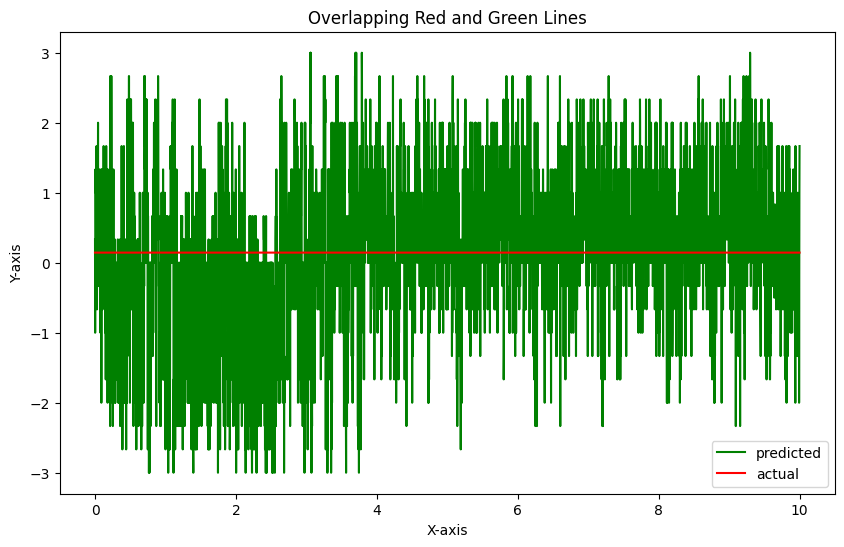

In [ ]:
import matplotlib.pyplot as plt

# Sample data (replace these with your actual data)
x = np.linspace(0, 10, 4659)  # Assuming you have 4659 data points
y1 = flatten_2d_array(denormPred)      # Replace with your first array data
y2 = flatten_2d_array(modelTestData['Label_denorm'])      # Replace with your second array data

# Create a figure and axis
plt.figure(figsize=(10, 6))  # Set the figure size

# Plot y1 and y2 as overlapping lines
plt.plot(x, y2, color='green', label='predicted')  # Green line for y2
plt.plot(x, y1, color='red', label='actual')    # Red line for y1

# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Overlapping Red and Green Lines')

# Add a legend
plt.legend()

# Show the plot
plt.show()

(array([ 311.,  760., 1125., 1459., 1083., 5715., 3116., 1739.,  811.,
         207.]),
 array([0.        , 0.1       , 0.2       , 0.30000001, 0.40000001,
        0.5       , 0.60000002, 0.69999999, 0.80000001, 0.89999998,
        1.        ]),
 <BarContainer object of 10 artists>)

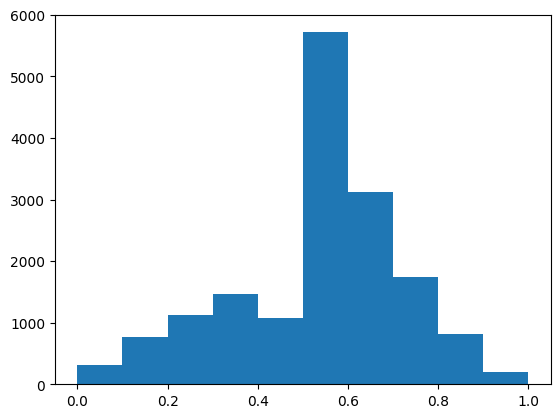

In [ ]:
plt.hist(modelTrainData['Label'])

In [ ]:
import numpy as np
import tensorflow as tf

# Assuming you have input_ids_data and attention_mask_data from BERT tokenization
num_samples = input_ids_data.shape[0]
sequence_length = input_ids_data.shape[1]

# Build the autoencoder model
input_layer = tf.keras.layers.Input(shape=(sequence_length,), dtype=tf.int32)
attention_mask = tf.keras.layers.Input(shape=(sequence_length,), dtype=tf.int32)

embedding_size = 768  # Assuming BERT embeddings

# You can use pretrained BERT embeddings here or learn embeddings with the autoencoder
# For simplicity, let's use a linear layer for embedding learning
encoded = tf.keras.layers.Dense(128, activation='relu')(input_layer)
encoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
encoded = tf.keras.layers.Dense(32, activation='relu')(encoded)

# Decoder
decoded = tf.keras.layers.Dense(64, activation='relu')(encoded)
decoded = tf.keras.layers.Dense(128, activation='relu')(decoded)
decoded = tf.keras.layers.Dense(embedding_size, activation='linear')(decoded)

autoencoder = tf.keras.Model(inputs=input_layer, outputs=decoded)

# Compile the model
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# Train the autoencoder
autoencoder.fit(input_ids_data, input_ids_data, epochs=10, batch_size=32, shuffle=True)

# Use the trained autoencoder for encoding and decoding
encoded_sequences = autoencoder.predict(input_ids_data)


NameError: name 'input_ids_data' is not defined

In [ ]:

# Save the model to a directory
model_final.save('./savedModel1')

# Optionally, you can save the tokenizer used for encoding the text data
# tokenizer.save_pretrained('./savedModels')

INFO:tensorflow:Assets written to: ./savedModel1/assets


INFO:tensorflow:Assets written to: ./savedModel1/assets
